# 🌿 AI-Powered IoT Twin for Multi-Objective Optimization of Energy, Air Quality & Comfort in Smart Sustainable Buildings

**Phase 1 (Enhanced Version)** — This notebook simulates IoT sensor data for a smart building, trains forecasting models
for **energy**, **CO₂ (air quality)** and **comfort**, computes a composite **Smart Sustainability Score**, and exports a CSV
for use in the Streamlit dashboard.

**Pipeline**
1) Data Simulation (hourly for 1 year) with realistic dynamics  
2) Feature Engineering (timestamp, derived targets)  
3) ML Modeling (Linear Regression baselines)  
4) Rule-Based Recommendations (actionable insights)  
5) Visualization (time-series, distributions, correlations)  
6) Export CSV (`smart.csv`) for Streamlit

> Tip: This file is intentionally framework-agnostic—swap models with RandomForest/XGBoost or LSTM later.

In [1]:

# ====== Imports & Config ======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Reproducibility
np.random.seed(42)

# Matplotlib defaults (no styles or explicit colors per guidance)
plt.rcParams.update({
    "figure.figsize": (10, 4),
    "axes.grid": True
})


## 1) Simulate IoT Sensor Data (Hourly, 1 Year)

In [2]:

# Constants
days = 365
hours_per_day = 24
total_hours = days * hours_per_day

# Time features
hour = np.tile(np.arange(24), days)
timestamp = pd.date_range(start="2024-01-01", periods=total_hours, freq="H")

# Environmental variables
temperature = 20 + 5 * np.sin((hour - 6) * np.pi / 12) + np.random.normal(0, 1, total_hours)
humidity = 50 + 10 * np.cos((hour - 6) * np.pi / 12) + np.random.normal(0, 2, total_hours)

# Occupancy & ventilation
occupancy = np.where((hour >= 8) & (hour <= 20),
                     np.random.poisson(3, total_hours),
                     np.random.poisson(1, total_hours))
occupancy = np.clip(occupancy, 0, 10)

ventilation_on = np.where((hour >= 9) & (hour <= 17) & (occupancy > 2), 1, 0)

# Appliance load (kW)
appliance_load_kw = 0.3 * occupancy + 1.5 * ((hour >= 18) & (hour <= 22)).astype(int)
appliance_load_kw += np.random.normal(0, 0.5, total_hours)

# Assemble dataframe
data = pd.DataFrame({
    "timestamp": timestamp,
    "hour": hour,
    "temperature": temperature.round(2),
    "humidity": humidity.round(2),
    "occupancy": occupancy,
    "ventilation_on": ventilation_on,
    "appliance_load_kw": appliance_load_kw.round(2)
}).set_index("timestamp")

data.head()


C:\Users\akc55\AppData\Local\Temp\ipykernel_11168\2333888672.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamp = pd.date_range(start="2024-01-01", periods=total_hours, freq="H")


,hour,temperature,humidity,occupancy,ventilation_on,appliance_load_kw
timestamp,,,,,,
2024-01-01 00:00:00,0,15.50,51.94,1,0,0.32
2024-01-01 01:00:00,1,15.03,50.00,0,0,-0.25
2024-01-01 02:00:00,2,16.32,52.62,1,0,0.18
2024-01-01 03:00:00,3,17.99,58.23,4,0,0.67
2024-01-01 04:00:00,4,17.27,58.53,1,0,-0.48


## 2) Derive Targets: CO₂ and Comfort

In [3]:

# CO₂ ppm based on occupancy & ventilation
co2 = 400 + 20 * data["occupancy"] - 100 * data["ventilation_on"] + np.random.normal(0, 30, len(data))
data["co2_ppm"] = np.clip(co2, 350, 2000).round(1)

# Comfort index
comfort_index = 100 - 4 * abs(data["temperature"] - 22) - 0.5 * abs(data["humidity"] - 50)
data["comfort_index"] = np.clip(comfort_index, 0, 100).round(1)

data[["occupancy", "ventilation_on", "co2_ppm", "comfort_index"]].head()


,occupancy,ventilation_on,co2_ppm,comfort_index
timestamp,,,,
2024-01-01 00:00:00,1,0,458.9,73.0
2024-01-01 01:00:00,0,0,390.0,72.1
2024-01-01 02:00:00,1,0,386.7,76.0
2024-01-01 03:00:00,4,0,474.3,79.8
2024-01-01 04:00:00,1,0,356.6,76.8


## 3) Baseline ML Models (Linear Regression)

In [4]:

# Features
features = ["hour", "temperature", "humidity", "occupancy", "ventilation_on"]

# 3a) Energy model
X_e = data[features]
y_e = data["appliance_load_kw"]
Xe_train, Xe_test, ye_train, ye_test = train_test_split(X_e, y_e, test_size=0.2, random_state=42)
m_energy = LinearRegression().fit(Xe_train, ye_train)
y_e_pred = m_energy.predict(Xe_test)
print("Energy R2:", round(r2_score(ye_test, y_e_pred), 3))
print("Energy MSE:", round(mean_squared_error(ye_test, y_e_pred), 2))

# 3b) CO2 model
X_c = data[features]
y_c = data["co2_ppm"]
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_c, y_c, test_size=0.2, random_state=42)
m_co2 = LinearRegression().fit(Xc_train, yc_train)
y_c_pred = m_co2.predict(Xc_test)
print("CO2 R2:", round(r2_score(yc_test, y_c_pred), 3))
print("CO2 MSE:", round(mean_squared_error(yc_test, y_c_pred), 2))

# 3c) Comfort model
X_t = data[features]
y_t = data["comfort_index"]
Xt_train, Xt_test, yt_train, yt_test = train_test_split(X_t, y_t, test_size=0.2, random_state=42)
m_comfort = LinearRegression().fit(Xt_train, yt_train)
y_t_pred = m_comfort.predict(Xt_test)
print("Comfort R2:", round(r2_score(yt_test, y_t_pred), 3))
print("Comfort MSE:", round(mean_squared_error(yt_test, y_t_pred), 2))


Energy R2: 0.597
Energy MSE: 0.38
CO2 R2: 0.555
CO2 MSE: 822.94
Comfort R2: 0.662
Comfort MSE: 26.05


## 4) Smart Sustainability Score (Composite)

In [5]:

# Normalize components and combine
smart_score = (
    0.4 * (100 - (data["appliance_load_kw"] / data["appliance_load_kw"].max()) * 100) +
    0.3 * (100 - (data["co2_ppm"] / 2000) * 100) +
    0.3 * data["comfort_index"]
)
data["smart_score"] = smart_score.round(2)
data[["appliance_load_kw", "co2_ppm", "comfort_index", "smart_score"]].head()

# 🌎 Carbon Impact Estimator
data["carbon_savings_kg"] = (data["appliance_load_kw"].max() - data["appliance_load_kw"]) * 0.92


## 5) Rule-Based Recommendations

In [6]:

def generate_recommendations(row):
    recs = []

    # Energy
    if row["occupancy"] <= 1 and 6 <= row["hour"] <= 17:
        recs.append("Run only essential appliances")
    elif row["appliance_load_kw"] > 2.5:
        recs.append("Reduce appliance usage")

    # Air quality
    if row["co2_ppm"] > 1000 and row["ventilation_on"] == 0:
        recs.append("Turn ON ventilation")

    # Comfort
    if row["comfort_index"] < 60:
        if row["temperature"] < 20:
            recs.append("Increase heating")
        elif row["temperature"] > 26:
            recs.append("Use air conditioning")
        if row["humidity"] < 40:
            recs.append("Use humidifier")
        elif row["humidity"] > 60:
            recs.append("Use dehumidifier")

    return "; ".join(recs) if recs else "No action needed"

data["recommendation"] = data.apply(generate_recommendations, axis=1)
data[["hour","occupancy","temperature","humidity","co2_ppm","comfort_index","appliance_load_kw","recommendation"]].head(10)


,hour,occupancy,temperature,humidity,co2_ppm,comfort_index,appliance_load_kw,recommendation
timestamp,,,,,,,,
2024-01-01 00:00:00,0,1,15.50,51.94,458.9,73.0,0.32,No action needed
2024-01-01 01:00:00,1,0,15.03,50.00,390.0,72.1,-0.25,No action needed
2024-01-01 02:00:00,2,1,16.32,52.62,386.7,76.0,0.18,No action needed
2024-01-01 03:00:00,3,4,17.99,58.23,474.3,79.8,0.67,No action needed
2024-01-01 04:00:00,4,1,17.27,58.53,356.6,76.8,-0.48,No action needed
2024-01-01 05:00:00,5,1,18.47,58.75,415.6,81.5,0.35,No action needed
2024-01-01 06:00:00,6,1,21.58,62.03,350.0,92.3,-0.36,Run only essential appliances
2024-01-01 07:00:00,7,0,22.06,60.03,401.3,94.7,0.19,Run only essential appliances
2024-01-01 08:00:00,8,4,22.03,58.77,513.8,95.5,1.33,No action needed


## 6) Visualizations

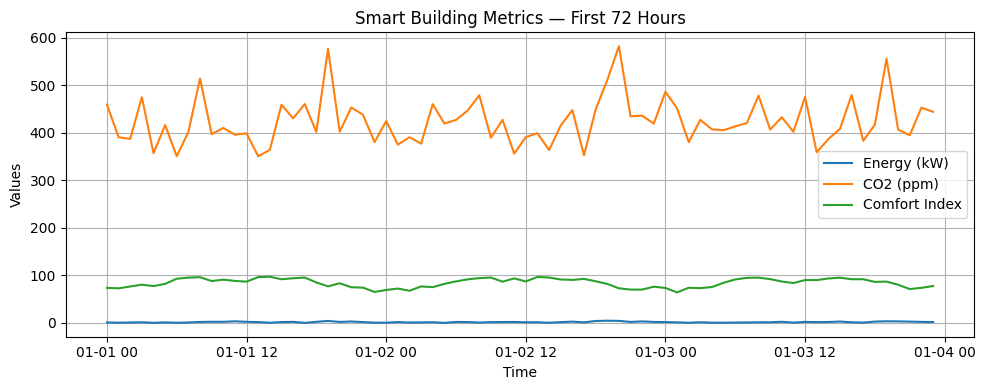

In [7]:

# 72-hour subset for clarity
subset = data.iloc[:72]

# 6a) Time-series overview
plt.figure()
plt.plot(subset.index, subset["appliance_load_kw"], label="Energy (kW)")
plt.plot(subset.index, subset["co2_ppm"], label="CO2 (ppm)")
plt.plot(subset.index, subset["comfort_index"], label="Comfort Index")
plt.title("Smart Building Metrics — First 72 Hours")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.tight_layout()
plt.show()


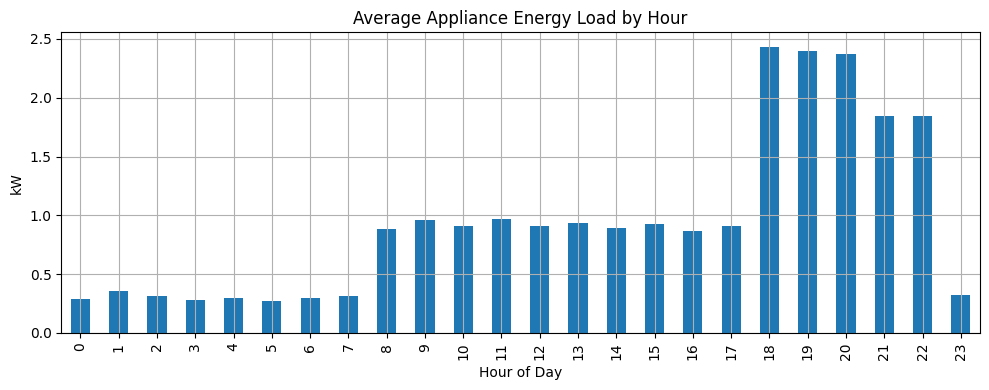

In [8]:

# 6b) Average energy by hour
hourly_energy = data.groupby("hour")["appliance_load_kw"].mean()
plt.figure()
hourly_energy.plot(kind="bar")
plt.title("Average Appliance Energy Load by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("kW")
plt.tight_layout()
plt.show()


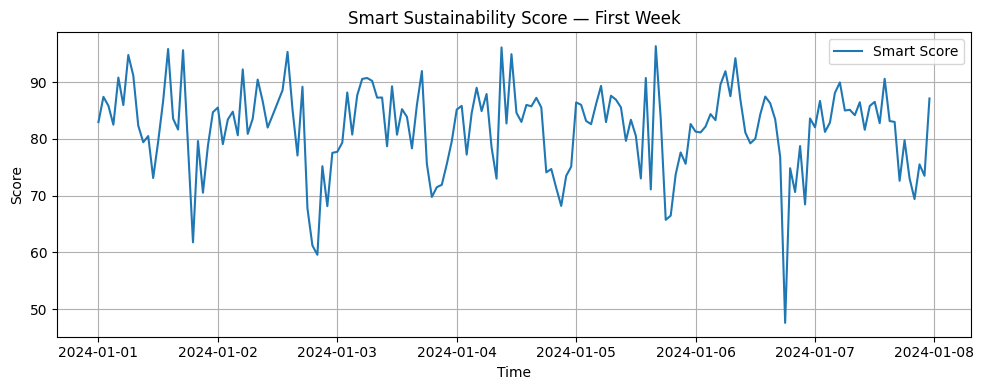

In [9]:

# 6c) Smart score over time (first week)
one_week = data.iloc[:24*7]
plt.figure()
plt.plot(one_week.index, one_week["smart_score"], label="Smart Score")
plt.title("Smart Sustainability Score — First Week")
plt.xlabel("Time")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()


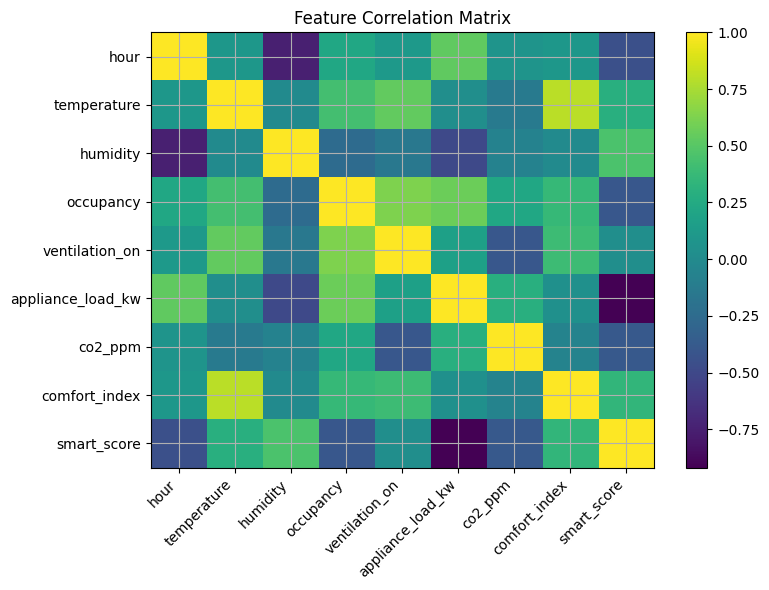

In [10]:

# 6d) Correlation heatmap (matplotlib only)
corr = data[["hour","temperature","humidity","occupancy","ventilation_on",
             "appliance_load_kw","co2_ppm","comfort_index","smart_score"]].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()


## 7) Export for Streamlit

In [11]:

# Export CSV for the Streamlit app
out_path = "smart.csv"
data.reset_index().to_csv(out_path, index=False)
print("✅ Data exported for Streamlit dashboard at:", out_path)


✅ Data exported for Streamlit dashboard at: smart.csv



### Next Steps
- Swap Linear Regression with RandomForestRegressor or XGBoost for non-linear performance.
- Add seasonal/weekly trends, holidays, or weather API inputs for richer realism.
- Split by multiple buildings and use Flower/TensorFlow Federated to prototype Phase 2 (FL).
- Connect this CSV to your Streamlit dashboard and iterate on UI/UX.
